In [1]:
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import numpy as np

We know that the XOR function for two binary variables produces a non-linearly separable dataset.

In [2]:
X = np.array([[1,0,0],
             [1,0,1],
             [1,1,0],
             [1,1,1]])
y = np.array([-1, 1, 1, -1])

This data is therefore impossible to learn with a linear classifier, like the *primal* perceptron. 

However, we can use the *kernel* perceptron (derived from the dual problem) to learn this non-linear relationship.

In [3]:
class KernelPerceptron():
    def __init__(self, kernel, kernel_args={}):
        self.gram = None
        self.alphas = None
        self.kernel = kernel
        self.kernel_args = kernel_args
        
    def fit(self, X, y, max_iter=100):
        self.gram = self.kernel(X, X, **self.kernel_args)
        self.alphas = np.zeros(X.shape[0])
        self.X = X
        self.y = y
        
        for _ in range(max_iter):
            for i, x_i in enumerate(X):
                y_hat = np.sign(np.sum(self.alphas * self.y * self.gram[:, i]))
                
                if y_hat != self.y[i]:
                    self.alphas[i] += 1
                    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, x_prime in enumerate(X):
            y_pred[i] = np.sign(np.sum(self.alphas * self.y * self.kernel(self.X, x_prime, **self.kernel_args)))
            
        return y_pred 


We define the polynomial kernel as:
\begin{align*}
    K(\mathbf{x'}, \mathbf{x}) = (1 + \mathbf{x'} \cdot \mathbf{x})^d
\end{align*}

for a degree parameter $d \in \mathbf{R}$.

In [4]:
def polynomial_kernel(x, y, d=2):
    y = y.T
    return (1 + x@y)**d

In [5]:
def plot_decision_boundary(X, y, clf, ax, idxs=(1,2), bias=True):
    x_min, x_max = X[:, idxs[0]].min() - 1, X[:, idxs[0]].max() + 1
    y_min, y_max = X[:, idxs[1]].min() - 1, X[:, idxs[1]].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x_p = np.c_[xx.ravel(), yy.ravel()]
    if bias == True:
        biases = np.ones(xx.ravel().shape[0])
        x_p = np.c_[biases.ravel(), xx.ravel(), yy.ravel()]
        
    z = clf.predict(x_p)
    z = z.reshape(xx.shape)
    ax.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.4)
    ax.scatter(X[:, idxs[0]], X[:, idxs[1]], c=y, cmap=plt.cm.RdBu)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_title(f"Plot of Decision Boundary for {clf.__class__.__name__} for {kp.kernel_args}")

In [6]:
kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": 2})
kp.fit(X, y)

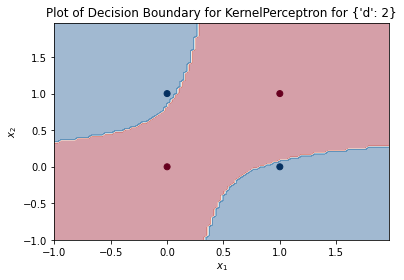

In [7]:
plot_decision_boundary(X, y, kp, plt.subplot(111))

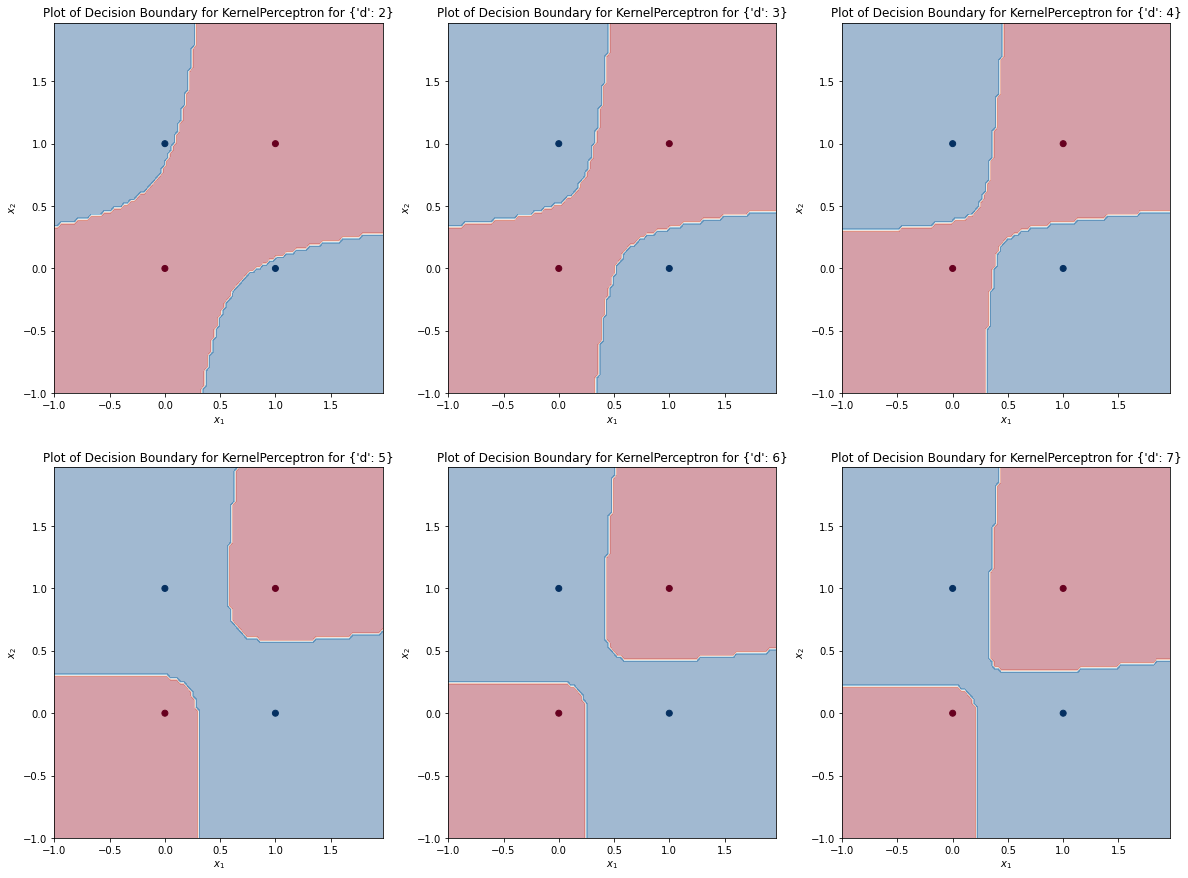

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
d_grid = np.arange(2, 8)
for i, ax in enumerate(axs.flat):
    kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": d_grid[i]})
    kp.fit(X, y)
    plot_decision_boundary(X, y, kp, ax)

Let's visualise the SVM and its different Kernels.

[SVM-demo](https://jgreitemann.github.io/svm-demo)

In [13]:
def hinge_loss(X, y, w, b):
    return np.clip(1-y*(X@w - b), 0, 100)

In [14]:
w = np.array([0.5, 1, 0.4])

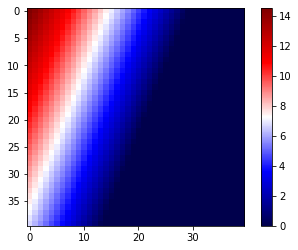

In [15]:
h = 0.5 
xx, yy = np.meshgrid(np.arange(-10, 10, h), np.arange(-10, 10, h))
y_c = np.ones(xx.ravel().shape[0])
plt.subplot(1, 1, 1)
biases = np.ones(xx.ravel().shape[0])
z = hinge_loss(np.c_[biases.ravel(), xx.ravel(), yy.ravel()], y_c, w, 0)
z = z.reshape(xx.shape)
#plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.4)
plt.imshow(z, cmap="seismic")
plt.colorbar()

plt.show()